# Limit 

## Set Up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re
import json
import pickle
import pandas as pd
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[3]))

from scripts.feature_extractions.gigahorse import get_n_gram_from_gigahorse_assessment


In [3]:
PATH = Path.cwd().parents[3]
MODEL_PATH = os.path.join(PATH, 'models/baseline')
DATA_PATH = os.path.join(PATH, 'data')
EX_PATH = os.path.join(DATA_PATH, 'external/crpwarner/large')
HEX_PATH = os.path.join(EX_PATH, 'hex')

## Load and Prepare Data

In [4]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/limit.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,Yes
0xa623b5a542c0d7daadef321042a04c600b03a8cb,Yes
0xe412189da2dfa188a1a61633114b8732bbbfba19,Yes
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,Yes
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,Yes


In [5]:
df.isna().sum()

TP?    0
dtype: int64

In [6]:
files = []
addresses = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    filename = path.name
    if address in df.index:
        addresses.append(address)
        files.append(filename)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)


X = get_n_gram_from_gigahorse_assessment(EX_PATH, addresses, files)

assessing: 91it [00:00, 279211.17it/s]


In [7]:
X

,add calldataload,add calldataload push,add dup,add dup add,add dup calldataload,add dup dup,add dup iszero,add dup push,add dup sload,add dup swap,...,swap swap div,swap swap dup,swap swap mstore,swap swap or,swap swap pop,swap swap push,swap swap sha,swap swap sstore,swap swap swap,timestamp gt
0,0,0,41,5,0,6,0,0,15,5,...,0,19,17,2,9,8,3,5,49,3
1,0,0,2,0,0,2,0,0,0,0,...,0,9,0,0,21,11,0,0,31,0
2,10,7,13,0,0,5,0,3,0,5,...,0,13,12,1,12,7,0,9,35,0
3,10,6,12,2,0,5,0,1,0,4,...,1,9,7,1,7,5,0,1,13,0
4,0,0,16,0,1,12,1,2,0,0,...,0,16,0,0,23,2,0,0,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0,0,38,0,0,5,0,7,4,21,...,5,9,7,4,2,1,5,4,37,2
87,0,0,25,0,0,17,0,8,0,0,...,0,10,0,0,22,3,0,0,24,0
88,11,8,8,2,0,4,0,0,0,2,...,2,10,7,1,6,6,0,4,21,0
89,1,0,13,0,0,10,0,2,0,1,...,0,2,6,0,6,4,0,0,3,0


In [8]:
len(y), len(X)

(91, 91)

In [9]:
with open(os.path.join(DATA_PATH, 'processed/ir_gigahorse/grouping_n_grams_features.json'), 'r', encoding='utf-8') as f:
    train_cols = json.load(f)

In [10]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)
X.head()

,add add,add add mstore,add add swap,add and,add and dup,add calldataload,add calldataload push,add calldataload swap,add dup,add dup add,...,swap swap div,swap swap dup,swap swap mstore,swap swap or,swap swap pop,swap swap push,swap swap sha,swap swap sstore,swap swap swap,timestamp push
0,0,0,0,0,0,0,0,0,41,5,...,0,19,17,2,9,8,3,5,49,0
1,0,0,0,0,0,0,0,0,2,0,...,0,9,0,0,21,11,0,0,31,0
2,0,0,0,0,0,10,7,0,13,0,...,0,13,12,1,12,7,0,9,35,0
3,0,0,0,0,0,10,6,0,12,2,...,1,9,7,1,7,5,0,1,13,0
4,0,0,0,0,0,0,0,0,16,0,...,0,16,0,0,23,2,0,0,34,0


## Load Model and Evaluate

In [11]:
model_paths = list(Path(MODEL_PATH).glob('limit-*.pkl'))

In [12]:
def get_best_model_path(paths):
    best_f1_score = -1.0
    best_path = None

    for path in paths:
        # Extract the F1 score using a regular expression
        match = re.search(r'f1-(\d+\.\d+)\.(pkl|json|keras)$', path.name)
        if match:
            try:
                f1_score = float(match.group(1))
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    best_path = path
            except ValueError:
                # Handle cases where the extracted string might not be a valid float
                print(f"Warning: Could not parse F1 score from filename: {path.name}")
        else:
            print(f"Warning: F1 score pattern not found in filename: {path.name}")

    return best_path

In [13]:
best_model_path = get_best_model_path(model_paths)

if best_model_path:
    model = pickle.load(open(best_model_path, 'rb'))

In [14]:
y_pred = model.predict(X)

In [15]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.85      0.23        13
           1       0.75      0.08      0.14        78

    accuracy                           0.19        91
   macro avg       0.44      0.46      0.18        91
weighted avg       0.66      0.19      0.15        91



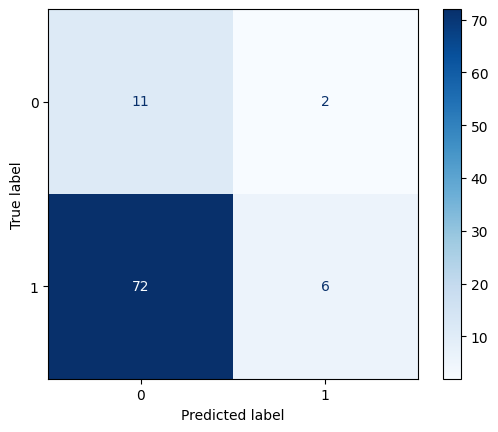

In [16]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()